In [185]:

import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import os
import urllib.request

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error


In [186]:

# Download data if not exists
def download_data():
    data_dir = "./data"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    files = [
        ("green_tripdata_2021-01.parquet", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"),
        ("green_tripdata_2021-02.parquet", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
    ]
    
    for filename, url in files:
        filepath = os.path.join(data_dir, filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
        else:
            print(f"{filename} already exists.")

download_data()


green_tripdata_2021-01.parquet already exists.
green_tripdata_2021-02.parquet already exists.


In [187]:

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-car-data")


<Experiment: artifact_location='/home/rahul/mlops/mlruns/1', creation_time=1769842401345, experiment_id='1', last_update_time=1769842401345, lifecycle_stage='active', name='nyc-car-data', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [188]:

def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


In [189]:

df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')
print(f"Train size: {len(df_train)}, Val size: {len(df_val)}")


Train size: 73908, Val size: 61921


In [190]:

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [191]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
print(f"Linear Regression Validation RMSE: {rmse}")


Linear Regression Validation RMSE: 7.758715199213814


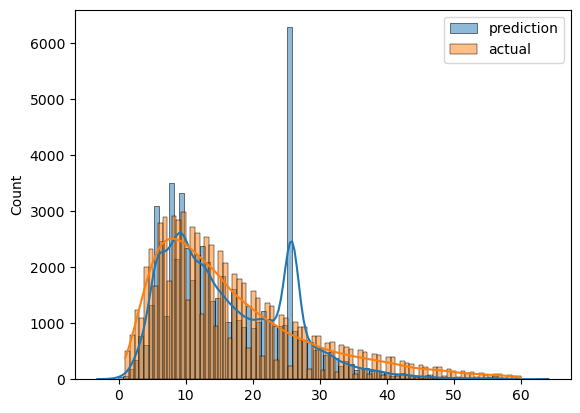

In [192]:

sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual', kde=True)
plt.legend()
plt.show()


In [193]:

if not os.path.exists('models'):
    os.makedirs('models')
    
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)


In [194]:

with mlflow.start_run():
    mlflow.set_tag("developer", "papazii")

    # Log params
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.2
    mlflow.log_param("alpha", alpha)
    
    lr_lasso = Lasso(alpha)
    lr_lasso.fit(X_train, y_train)

    y_pred_lasso = lr_lasso.predict(X_val)
    
    # Use root_mean_squared_error instead of mean_squared_error(squared=False)
    rmse = root_mean_squared_error(y_val, y_pred_lasso)
    
    mlflow.log_metric("rmse", rmse)
    print(f"Lasso RMSE: {rmse}")

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")


Lasso RMSE: 12.212582257436557


In [195]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/rahul/anaconda3/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/rahul/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [09:43:34] WARNING: /workspace/src/objective/regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.93964                                                     
[1]	validation-rmse:7.55754                                                     
[2]	validation-rmse:7.01098                                                     
[3]	validation-rmse:6.79202                                                     
[4]	validation-rmse:6.68598                                                     
[5]	validation-rmse:6.63719                                                     
[6]	validation-rmse:6.61256                                                     
[7]	validation-rmse:6.59495                                                     
[8]	validation-rmse:6.58522                                                     
[9]	validation-rmse:6.57775                                                     
[10]	validation-rmse:6.57400                                                    
[11]	validation-rmse:6.56980                                                    
[12]	validation-rmse:6.56631

job exception: got an unexpected keyword argument 'squared'



  0%|                                    | 0/50 [00:45<?, ?trial/s, best loss=?]


TypeError: got an unexpected keyword argument 'squared'

In [197]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/rahul/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [09:50:05] WARNING: /workspace/src/objective/regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

2026/01/31 09:51:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
